## Imports

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# import and read csv
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ast import literal_eval
import numpy as np
import string
import re

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MultiLabelBinarizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Perform exploratory data analysis

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = "https://drive.google.com/file/d/18ZGW-c3oDNIEmBFUfzXl2v0v04mkSlJc/view"
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('arxiv.csv')  
  
arxiv_data = pd.read_csv('arxiv.csv')
arxiv_data.head()

,titles,summaries,terms
0,Revealing the Field Sub-subgiant Population Using a Catalog of Active Giant Stars and Gaia EDR3,"Sub-subgiant stars (SSGs) fall below the subgiant branch and/or red of the\ngiant branch in open and globular clusters, an area of the color-magnitude\ndiagram (CMD) not populated by standard stellar evolution tracks. One\nhypothesis is that SSGs result from rapid rotation in subgiants or giants...","['astro-ph.SR', 'astro-ph.GA']"
1,ALMA detection of ethyl cyanide and methyl formate in the hot molecular core IRAS 18566+0408,"In millimeter/submillimeter wavelength, the studies of the complex molecular\nemission lines towards the hot molecular cores demonstrate valuable details\nabout the chemical composition and massive star formation processes. We present\nthe interferometric detection of rotational molecular emissi...",['astro-ph.GA']
2,Accretion processes in the galaxy cluster Hydra A/Abell 780,"Clusters of galaxies evolve and accrete mass, mostly from small galaxy\nsystems. Our aim is to study the velocity field of the galaxy cluster Abell\n780, which is known for the powerful radio source Hydra A at its center and\nwhere a spectacular X-ray tail associated with the galaxy LEDA 87445 h...","['astro-ph.CO', 'astro-ph.GA']"
3,Radio astronomy locates the neutrino origin in bright blazars,"High-energy astrophysical neutrinos have been observed by several telescopes\nin the last decade, but their sources still remained unknown. We address the\nproblem of locating astrophysical neutrinos' sources in a statistical manner.\nWe show that blazars positionally associated with IceCube neu...","['astro-ph.HE', 'astro-ph.GA']"
4,The extragalactic $γ$-ray background: imprints from the physical properties and evolution of star-forming galaxy populations,"Star-forming galaxies (SFGs) are expected to harbour an abundant reservoir of\ncosmic rays (CRs). At GeV energies, these CRs can undergo hadronic interactions\nwith interstellar gases to produce $\gamma$-rays, and the unresolved\n$\gamma$-ray emission from populations of SFGs form a component of...","['astro-ph.GA', 'astro-ph.HE']"


In [ ]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 89336 rows in the dataset.


In [ ]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 19134 duplicate titles.


In [ ]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 70202 rows in the deduplicated dataset.
22
152


In [ ]:
arxiv_data_filtered = arxiv_data

## Convert the string labels to lists of strings

In [ ]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['astro-ph.SR', 'astro-ph.GA']), list(['astro-ph.GA']),
       list(['astro-ph.CO', 'astro-ph.GA']),
       list(['astro-ph.HE', 'astro-ph.GA']),
       list(['astro-ph.GA', 'astro-ph.HE'])], dtype=object)

In [ ]:
dict_len = {}
for i in range(arxiv_data_filtered.shape[0]):
    if(len(arxiv_data_filtered.iloc[i]["terms"]) not in dict_len):
        dict_len[len(arxiv_data_filtered.iloc[i]["terms"])] = 1
    else:
        dict_len[len(arxiv_data_filtered.iloc[i]["terms"])] += 1
print("Occurancy of number of labels in a term: ")
dict_len = dict(sorted(dict_len.items(), key=lambda item: item[1], reverse=True))
for k, v in dict_len.items():
    print(f" - The number of paper have {k} labels in it's term: {v}")

Occurancy of number of labels in a term: 
 - The number of paper have 1 labels in it's term: 46399
 - The number of paper have 2 labels in it's term: 20635
 - The number of paper have 3 labels in it's term: 2904
 - The number of paper have 4 labels in it's term: 209
 - The number of paper have 5 labels in it's term: 54
 - The number of paper have 6 labels in it's term: 1


##Pre-processing dataset


In [ ]:
all_terms = sum(arxiv_data_filtered["terms"],[])
all_terms = nltk.FreqDist(all_terms) 
# create dataframe
all_terms_df = pd.DataFrame({'Term': list(all_terms.keys()), 
                              'Count': list(all_terms.values())})

In [ ]:
def clean_text(text):
  # remove new line characters
  text = re.sub(r"\n", " ", text)
  # remove email
  text = re.sub(r"([A-Za-z0-9_.+-]+@[A-Za-z0-9-]+\.?[A-Za-z0-9-.]+)", "", text)
  # remove url
  text = re.sub(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "", text)
  # remove punctuation
  text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
  # remove words including numbers
  text = re.sub(r"\w*\d\w*", "", text)
  # remove single character and duplicated words
  text = ' '.join(word for word in list(set(text.split())) if len(word) > 1)
  # replace multiple whitespace by one whitespace
  text = re.sub(r"\s+", " ", text)
  # lower all text
  text = text.lower()
  # strip all text
  text = text.strip()
  return text

In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  cleaned_text = []
  # turn text to a list of words
  word_list = text.split()
  for word in word_list:
    if word not in stop_words:
      cleaned_text.append(word)
  return ' '.join(cleaned_text)

In [ ]:
def lemmatize_text(text):
  wnl = WordNetLemmatizer()
  pos_text = pos_tag(word_tokenize(text))
  cleaned_text = []
  for word, tag in pos_text:
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lem_word = word
    else:
      lem_word = wnl.lemmatize(word, wntag)
    cleaned_text.append(lem_word)
  return ' '.join(cleaned_text)

In [ ]:
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(clean_text)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(remove_stopwords)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(lemmatize_text)
arxiv_data_filtered['summaries']

0        lower binary radius reference catalog sub cvns subgiant strong turn present gaia system fall dramatic rotation binary magnitude rapid star isochrone average include known dynamical shortest color one branch impact populate use hypothesis population tidal temperatures fraction cluster indicate rs...
1        ghz apply density equilibrium column original cn c strong statistical fractional valuable total mcmc chemical present detail cyanide frequency chain submillimeter determine time core formate respectively lte line spectrum composition estimate temperature three methyl ira local co markov algorith...
2        southeast redshift catalog associate smaller technique south small might source lie sight system em asymmetry conclude galaxy galaxy sigmav core slightly mostly italian may mass line analyze higher galileo know dynamical substructure vrf velocity accrete typical discover km first detect center l...
3        ghz lower significance associate vlbi strong statistical flare l

## Split training set, validation set and test set

In [ ]:
test_split = 0.3

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    # stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 49141
Number of rows in validation set: 10530
Number of rows in test set: 10531


## Multi-label binarization

In [ ]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'astro-ph.GA', 'astro-ph.SR', 'astro-ph.EP', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.CO']


In [ ]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['astro-ph.SR', 'astro-ph.HE']
Label-binarized representation: [[0. 0. 1. 0. 1. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects


In [ ]:
batch_size = 512
auto = tf.data.AUTOTUNE


def unify_text_length(text, label):
    return tf.expand_dims(text, -1), label


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(unify_text_length, num_parallel_calls=auto).cache()
    return dataset.batch(batch_size)


In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'include record trajectory arc precision allow state moment simulation image azimuths ten minute accord bolide improvement space video trace determination show fragment hundred iterative result method perform method angular measure atmosphere calibration altitude develop chelyabinsk distortion meter improve motion adjust compensation'
Label(s): ['astro-ph.EP' 'astro-ph.IM']
 
Abstract: b'eri apply averaged space epochs rho delta probably incomplete present amplitude characteristic mode identified frequency integer two search shift partly criteria multiplets hybrid scuti three four radial relation resonant use necessary colour amplitude variability prove pulsational linear derive found rotational different possible multiple star base photometry ground however reason space precise doublet among relative gcm exclude previously check publish spacing method multi couple sequence bar scaling develop one mode photometric discus widely combination satisfy sequence large discrepancy 

## Vectorization

In [ ]:
train_df["total_words"] = train_df["summaries"].str.split().str.len()
vocabulary_size = train_df["total_words"].max()
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 162


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


## Create a text classification model


In [ ]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model


## Train the model

Epoch 1/20
96/96 [==============================] - 6s 53ms/step - loss: 0.7949 - precision: 0.2750 - recall: 0.1292 - val_loss: 0.4542 - val_precision: 0.7081 - val_recall: 0.0078
Epoch 2/20
96/96 [==============================] - 4s 46ms/step - loss: 0.4446 - precision: 0.5131 - recall: 0.1087 - val_loss: 0.3788 - val_precision: 0.6430 - val_recall: 0.2950
Epoch 3/20
96/96 [==============================] - 5s 47ms/step - loss: 0.3759 - precision: 0.6177 - recall: 0.3524 - val_loss: 0.3216 - val_precision: 0.6873 - val_recall: 0.5391
Epoch 4/20
96/96 [==============================] - 5s 47ms/step - loss: 0.3258 - precision: 0.6948 - recall: 0.4954 - val_loss: 0.2879 - val_precision: 0.7127 - val_recall: 0.6369
Epoch 5/20
96/96 [==============================] - 5s 47ms/step - loss: 0.2976 - precision: 0.7331 - recall: 0.5689 - val_loss: 0.2711 - val_precision: 0.7436 - val_recall: 0.6503
Epoch 6/20
96/96 [==============================] - 5s 47ms/step - loss: 0.2825 - precision: 0.

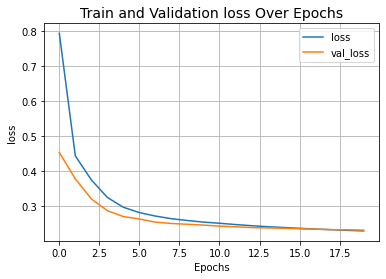

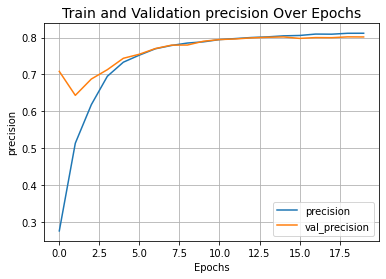

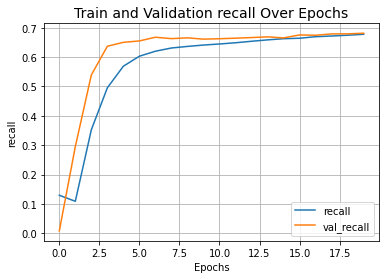

In [ ]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs,
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("precision")
plot_result("recall")

## Evaluate the model

###Exact Match Radio

In [ ]:
def get_y_true_and_y_pred_prob_value():
    model_for_evaluate = keras.Sequential([text_vectorizer, shallow_mlp_model])
    evaluate_dataset = make_dataset(test_df, is_train=False)

    y_true = []
    y_pred_prob = []

    for text_batch, label_batch in evaluate_dataset:
        predicted_probabilities = model_for_evaluate.predict(text_batch)
        for i, text in enumerate(text_batch):
            label = label_batch[i].numpy()[None, ...]
            y_true.append(label[0])
            y_pred_prob.append(predicted_probabilities[i])
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    return y_true, y_pred_prob


In [ ]:
def get_y_pred(y_pred_prob, k=3, threshold=0.5):
    y_pred = []
    for pred in y_pred_prob:
        top_k_labels = [
            x
            for _, x in sorted(
                zip(pred, lookup.get_vocabulary()),
                key=lambda pair: pair[0],
                reverse=True,
            )
        ][:k]
        y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
        for j in range(len(vocab)):
            if(vocab[j] in top_k_labels):
                if(pred[j] > threshold):
                    y_top_k_labels[j] = 1
                else:
                    top_k_labels.remove(vocab[j])
        y_pred.append(y_top_k_labels)
    y_pred = np.array(y_pred)   
    return y_pred


In [ ]:
y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
for k in range(1,7,1):
    for threshold in np.arange(0.3,0.8,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        number_of_test = test_df.shape[0]
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_true, y_pred)
        print(f"With k = {k} and threshold = {round(threshold,1)} - Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}%")

With k = 1 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 53.01%
With k = 1 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 52.9%
With k = 1 and threshold = 0.5 - Exact Match Radio accuracy on the test set: 52.37%
With k = 1 and threshold = 0.6 - Exact Match Radio accuracy on the test set: 50.9%
With k = 1 and threshold = 0.7 - Exact Match Radio accuracy on the test set: 47.79%
With k = 2 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 45.6%
With k = 2 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 50.96%
With k = 2 and threshold = 0.5 - Exact Match Radio accuracy on the test set: 53.2%
With k = 2 and threshold = 0.6 - Exact Match Radio accuracy on the test set: 52.48%
With k = 2 and threshold = 0.7 - Exact Match Radio accuracy on the test set: 48.71%
With k = 3 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 44.74%
With k = 3 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 50.

### Hamming Loss

In [ ]:
from sklearn.metrics import hamming_loss
y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)
hml = hamming_loss(y_true, y_pred)
print(f"Hamming Loss = {round(hml, 5)}")

Hamming Loss = 0.09682


### Confusion Matrix Metrics

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)

m = multilabel_confusion_matrix(y_true, y_pred)

for i in range(1,len(m)):
    print("Multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()
    # print(vocab[i])

Multilabel_confusion_matrix_of: astro-ph.GA
[[6780  443]
 [ 974 2334]]

Multilabel_confusion_matrix_of: astro-ph.SR
[[6989  593]
 [1032 1917]]

Multilabel_confusion_matrix_of: astro-ph.EP
[[7601  370]
 [ 478 2082]]

Multilabel_confusion_matrix_of: astro-ph.HE
[[7899  383]
 [ 765 1484]]

Multilabel_confusion_matrix_of: astro-ph.IM
[[8060  376]
 [ 747 1348]]

Multilabel_confusion_matrix_of: astro-ph.CO
[[8711  292]
 [ 684  844]]



### Precision, Recall, F1_score, micro-average, macro-average metrics

In [ ]:
from sklearn.metrics import classification_report

y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)

print(classification_report(y_true, y_pred,target_names=vocab, zero_division = 0))

              precision    recall  f1-score   support

       [UNK]       0.00      0.00      0.00         0
 astro-ph.GA       0.84      0.71      0.77      3308
 astro-ph.SR       0.76      0.65      0.70      2949
 astro-ph.EP       0.85      0.81      0.83      2560
 astro-ph.HE       0.79      0.66      0.72      2249
 astro-ph.IM       0.78      0.64      0.71      2095
 astro-ph.CO       0.74      0.55      0.63      1528

   micro avg       0.80      0.68      0.74     14689
   macro avg       0.68      0.57      0.62     14689
weighted avg       0.80      0.68      0.74     14689
 samples avg       0.80      0.74      0.74     14689



### Exist 1 in Top k predicts is true Accuracy

In [ ]:
def top_k_predict_is_true_accuracy(y_true, y_pred_prob, k=3, threshold = 0.5):
    score = 0
    for i in range(len(y_pred_prob)):
            top_k_labels = [
                x
                for _, x in sorted(
                    zip(y_pred_prob[i], lookup.get_vocabulary()),
                    key=lambda pair: pair[0],
                    reverse=True,
                )
            ][:k]
            y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
            for label in top_k_labels:
                if(y_true[i][vocab.index(label)] == 1):
                    score += 1
                    break
    return score/len(y_pred_prob)

acc = top_k_predict_is_true_accuracy(y_true, y_pred_prob, 3, 0.5)
print(f"Accuracy: {round(acc, 5)}")

Accuracy: 0.9775


## Inference

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

k=6

# Perform inference.
for i, text in enumerate(text_batch[:50]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_k_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:k]
    predicted_proba.sort(reverse = True)
    for i in reversed(range(len(predicted_proba)-1)):
        if(predicted_proba[i] < 0.2 and len(top_k_labels) > 0):
            top_k_labels.pop(i)
    print(f"Predicted Label(s): ({', '.join([label for label in top_k_labels])})")
    print(" ")

Abstract: b'matter compare distribution operation determination mock body galaxy galaxy determine two correlation information recover analyze spectrum log anisotropies radial point function bias linear polar cdm dark base bias compare simulation survey band require least lambda distribution method catalogue apply one entropy azimuthal power parameter use find require method redshift sim simulate anisotropy show'
Label(s): ['astro-ph.CO']
Predicted Label(s): (astro-ph.CO, astro-ph.IM)
 
Abstract: b'compare dust density rho sph upper outward chemical present dd justify turbulent gas determine net lagrangian isotopic cosmochemistry flux composition appear stochastic physically eulerian diffusive transport particle important journey understand form trajectory use difficulty well different application code coefficient model allow midplane sample timesgrad numerical formalism order disk potential also however study overcomes protoplanetary favor discus alter induces procedure gaseous individ